## EDM Toy Example

With this toy example we illustrate the training efficiency of using CEDM (Conditional Entropy in Diffusion Models). We first: 

1. Re-implemente EDM using torch lightning and demostrate some equivalents to their vs SDE parameterizations.
2. Instead of sampling the noise levels using EDM heuristic samplers we sample from the conditional entropy.
3. Then, we propose our adaptive method.

### 1) DataLoader & Config File

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading Dataset...
Min-max normalizing data...


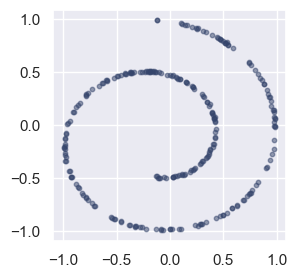

In [22]:
%load_ext autoreload
%autoreload 2

import hydra
import torch 
import matplotlib.pyplot as plt
from datamodules.toy_datasets import ToyDataModule
from utils.plots import plot_data

from training.losses import *
from training.noise_samplers.schedules import *
from training.noise_samplers.visualize import plot_sigma_distributions, plot_sigma_trajectories
from utils.data_utils import get_datamodule, rescaling_inv

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Loading Dataset...")
toy_dm = ToyDataModule(dataset_name="swiss_roll", 
                       num_samples=10000,
                       noise=0.05,
                       batch_size=256, 
                       num_workers=0, 
                       min_max_normalize=True)

# toy_dm = get_datamodule("cifar10", batch_size=256)

toy_dm.prepare_data()
toy_dm.setup()

# Get train dataloader
dataloader = toy_dm.train_dataloader()
x, _ = next(iter(dataloader))

# Plot toy data
plot_data(x)

In [24]:
import yaml
from omegaconf import OmegaConf

# Load the default config file 
if not hydra.core.global_hydra.GlobalHydra.instance().is_initialized():
    hydra.initialize(config_path="./config", version_base=None)
    config = hydra.compose(config_name="config")

# Print the config file as yaml
# Convert OmegaConf config to dict before dumping to YAML
config_dict = OmegaConf.to_container(config, resolve=True)
print(yaml.dump(config_dict, default_flow_style=False))

dataset:
  data_dim: 2
  name: swiss_roll
  num_samples: 100000
logging:
  log_every_n_steps: 50
  mode: min
  monitor: val_loss
  name: diffusion_experiment
  save_dir: results
  save_top_k: 3
  version: '1'
loss:
  P_mean: -1.2
  P_std: 1.2
  name: edm
  sigma_data: 0.5
model:
  class_conditional: false
  label_dim: 0
  name: edm
network:
  hidden_dim: 64
  input_dim: 2
  name: mlp
  num_hidden_layers: 6
  time_embedding_dim: 64
precond:
  P_mean: -1.2
  P_std: 1.2
  name: edm
  rho: 7.0
  sigma_data: 0.5
  sigma_max: 100.0
  sigma_min: 0.02
sampling:
  batch_size: 500
  eval_batch_size: 100
  eval_samples: 1000
  n_steps: 10
train:
  accelerator: auto
  accumulate_grad_batches: 1
  amp_backend: native
  batch_size: 256
  devices: 1
  entropy_interval: 5
  entropy_num_timesteps: 100
  gradient_clip_val: 1.0
  learning_rate: 0.001
  max_epochs: 500
  num_workers: 4
  precision: 16-mixed
  sampling_interval: 50
viz:
  figsize:
  - 6
  - 6
  num_samples: 1000
  plot_every_n_epochs: 5
  

### 2) Noise Schedulers and equivalence with SDE formulation

Rather than using complex formulation, EDM proposed to separate its complexity by proposing a unified framework that consists on only looking at the Gaussian kernel,


\begin{equation}
    p_{0t}(\mathbf{x}_t ~|~ \mathbf{x}_0) = \mathcal{N} \big( \mathbf{x}_t; ~s(t) ~\mathbf{x}_0, ~s(t)^2 ~\sigma(t)^2 ~\mathbf{I} \big) 
\end{equation}

To define a general framework, rather than having a noisy state directly by reparameterizing the Gaussian kernel, everything is defined for the VESDE case, where $s(t) =1$. This allows to define a general way to noise data via 

\begin{equation}
    \mathbf{x}_t  = \mathbf{x}_0 + \sigma(t) * \epsilon 
\end{equation}

The equivalence from VE to VP is possible by scaling the function, in practice this is done by a preconditioning network. 

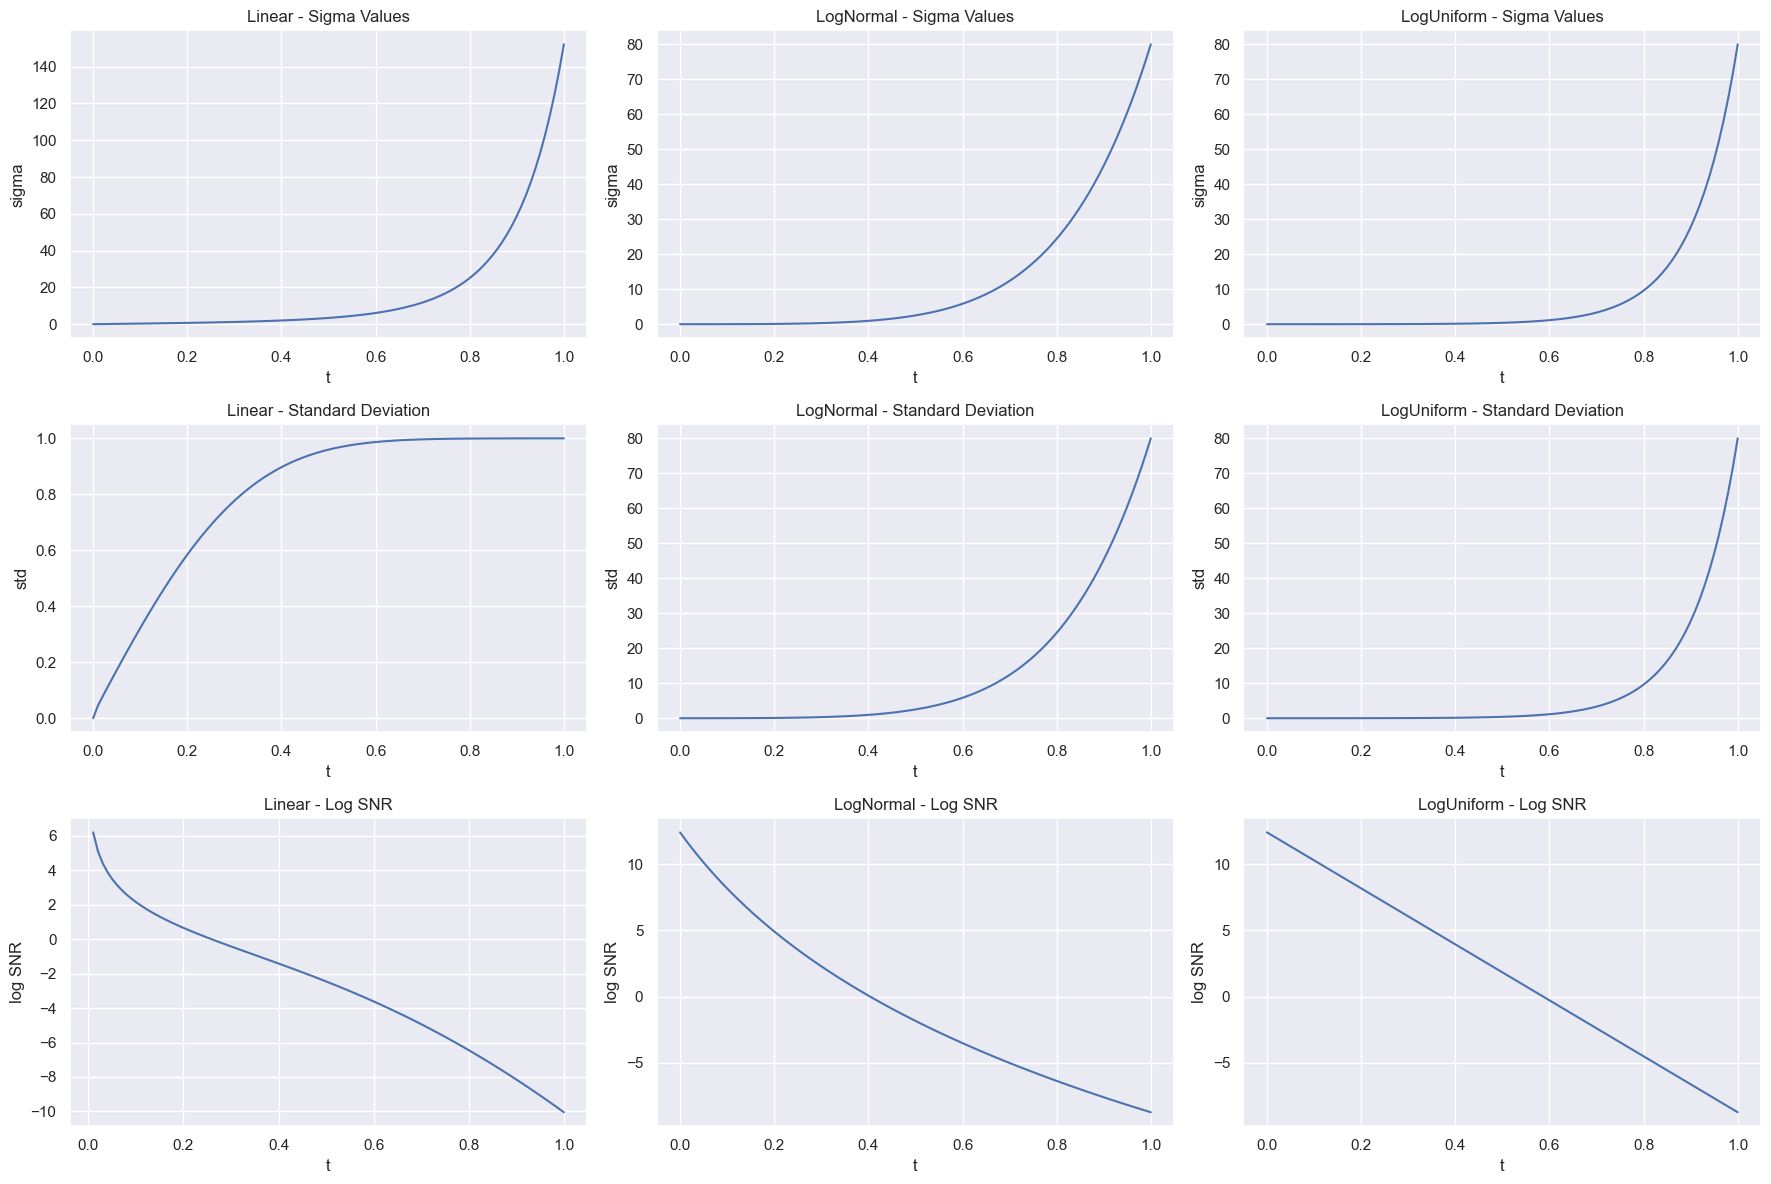

In [25]:
from training.noise_samplers.schedules import LinearNoiseSampler, LogNormalNoiseSampler, LogUniformNoiseSampler

# Create samplers for each type
samplers = {
    'Linear': LinearNoiseSampler(),
    'LogNormal': LogNormalNoiseSampler(),
    'LogUniform': LogUniformNoiseSampler()
}

# Create time points
t = torch.linspace(0, 1, 100)

# Create figure with subplots for each sampler
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Plot metrics for each sampler
for i, (name, sampler) in enumerate(samplers.items()):
    # Calculate metrics
    sigmas = sampler.sigma(t)
    s_t = sampler.signal(t)
    std = sigmas * s_t
    logsnr = sampler.logsnr(t)
    
    # Plot sigmas
    axes[0, i].plot(t, sigmas)
    axes[0, i].set_title(f'{name} - Sigma Values')
    axes[0, i].set_xlabel('t')
    axes[0, i].set_ylabel('sigma')
    
    # Plot standard deviation
    axes[1, i].plot(t, std)
    axes[1, i].set_title(f'{name} - Standard Deviation')
    axes[1, i].set_xlabel('t')
    axes[1, i].set_ylabel('std')
    
    # Plot log SNR
    axes[2, i].plot(t, logsnr)
    axes[2, i].set_title(f'{name} - Log SNR')
    axes[2, i].set_xlabel('t')
    axes[2, i].set_ylabel('log SNR')

plt.tight_layout()
plt.show()

## Visualize Forward Process

The EDM formulation is based on VE but how does VP looks for the noising process 

In [26]:
# Visualize Forward Process : TODO

# from training.noise_samplers.visualize import plot_forward_process_animation

# # Animated visualization
# plot_forward_process_animation(
#     x, sigma_sampler,
#     num_steps=50,  # Number of frames in animation
#     title='Forward Process Animation: Cosine Sampler'
# )

### Testing Nosing Process on Log Normal Noise Sampler

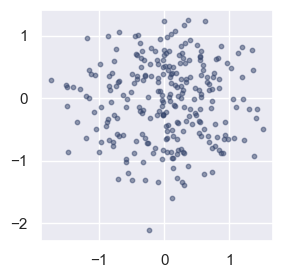

In [48]:
# Create Log Normal Noise Sampler
sigma_sampler = LogNormalNoiseSampler()

# Define a time step
t = 0.3 * torch.ones(x.shape[0])

# Generate a noisy state
noise = torch.randn_like(x)
sigmas = sigma_sampler.sigma(t)
noised_x = x + noise * expand_dims(sigmas, x.ndim)

# Visualize the noised data
plot_data(noised_x.cpu(), name="noised_toy_data", figsize=(3, 3))

## Networks

Now that we have define the noising process, we have to define the network that will predict the noise or signal. The EDM formulation cast everything to predict the signal (known as denoiser). For this purpose they proposed to construct a based model that acts similar to predicting the noise, and then a precondition netowk that accounts for scalings of the input/outputs: 

1. The noise prediction network (base model)
2. The Denoiser network using the EDM formulation

In [49]:
%load_ext autoreload
%autoreload 2
from networks.toy_network import MLP, AdvancedMLP
from models.lightning.edm_lightning import EDMLightning
import lightning as L
from networks.preconditioning import EDMDenoiser    
from utils.model_utils import get_model

if x.ndim == 2:
    # Base model 
    base_model = MLP(input_dim=2,
                    hidden_dim=config.network.hidden_dim, 
                    num_hidden_layers=config.network.num_hidden_layers, 
                    time_embedding_dim=config.network.time_embedding_dim)
    
    base_model = AdvancedMLP()

        # Choose Preconditioning scheme
    denoiser = EDMDenoiser(base_model, 
                        sigma_data=config.precond.sigma_data)
else:
    # Get Denoiser
    denoiser, base_model = get_model(config)

# Lightning Model
model = EDMLightning(model=denoiser, 
                     config=config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# Testing the denoiser with dummy input 
if x.ndim == 2:
    input = torch.randn(10, 2)
    sigma = torch.ones(10) * 0.1
else: 
    input = torch.randn(10, 3, 32, 32)
    sigma = torch.ones(10) * 0.1

output = denoiser(input, sigma, None, None)
print(output.shape)

output = model.forward(input, sigma, None)
print(output.shape)


torch.Size([10, 2])
torch.Size([10, 2])


In [52]:
trainer = L.Trainer(
                    max_epochs=40,
                    accelerator="gpu",
                    devices="auto",
)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [53]:
trainer.fit(model, toy_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



  | Name     | Type        | Params | Mode 
-------------------------------------------------
0 | denoiser | EDMDenoiser | 104 K  | train
-------------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.418     Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode


Min-max normalizing data...
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 226.52it/s]

/home/gabriel/miniconda3/envs/entropy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/gabriel/miniconda3/envs/entropy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/gabriel/miniconda3/envs/entropy/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 32/32 [00:00<00:00, 38.34it/s, v_num=19, train_loss_step=1.200, val_loss=0.937, train_loss_epoch=0.935]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 32/32 [00:00<00:00, 37.25it/s, v_num=19, train_loss_step=1.200, val_loss=0.937, train_loss_epoch=0.935]


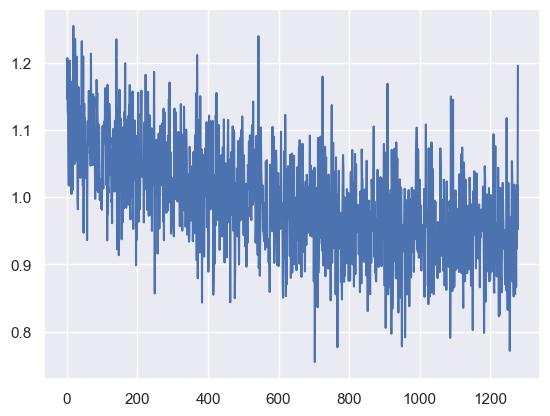

In [54]:
plt.plot(model.train_loss)

In [55]:
denoiser = model.denoiser.eval()

In [56]:
%load_ext autoreload
from inference import KarrasDiffEq, KarrasHeun2Solver,KarrasNoiseSchedule
from inference import sample_trajectory_batch

# Create ODE and solver
ode = KarrasDiffEq(denoiser)
solver = KarrasHeun2Solver()

# sampling noise schedule
noise_schedule = KarrasNoiseSchedule(
    sigma_data=config['precond']['sigma_data'],
    sigma_min=config['precond']['sigma_min'],
    sigma_max=config['precond']['sigma_max'],
    rho=config['precond']['rho']
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# Generate samples
samples = sample_trajectory_batch(
    input_shape=(2,),
    ode=ode,
    solver=solver,
    noise_schedule=noise_schedule,
    batch_size=500,
    n_steps=50,
    device=device
)

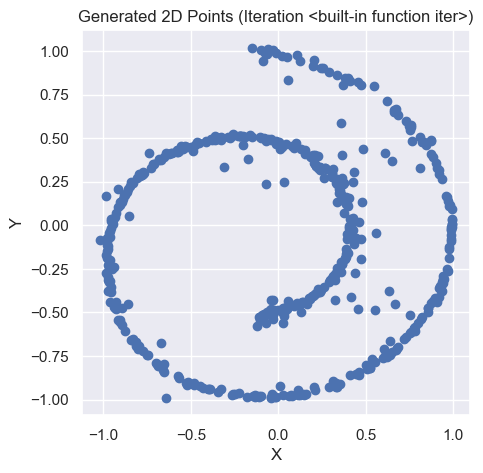

In [58]:
# Plot final samples
plt.figure(figsize=(5, 5))
final_samples = samples[-1].detach().cpu().numpy()
plt.scatter(final_samples[:, 0], final_samples[:, 1])
plt.title(f"Generated 2D Points (Iteration {iter})")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)

## Entropy Estimation 

**Gaussian kernel**

\begin{equation}
    p(x_t|x_0) = \mathcal{N}(x_t; s(t) x_0, s(t)^2 \sigma(t)^2 I)
\end{equation}

Leads to the following conditional entropy production 
\begin{equation} 
    \dot{\mathbf{H}}[\mathbf{x}_0|\mathbf{x}_t] = \frac{D \dot{\sigma}(t)}{\sigma(t)} - s(t)^2 \dot{\sigma}(t) \sigma(t) \mathbb{E}_{p_t(x_t)} [|| \nabla \log p_t(\mathbf{x}_t) ||^2 ]
\end{equation}

For EDM, with $\dot{\sigma}(t)=1$ this is 

\begin{equation} 
    \dot{\mathbf{H}}[\mathbf{x}_0|\mathbf{x}_t] = \frac{D}{t} - s(t)^2  \sigma(t) \mathbb{E}_{p_t(x_t)} [|| \nabla \log p_t(\mathbf{x}_t) ||^2 ]
\end{equation}

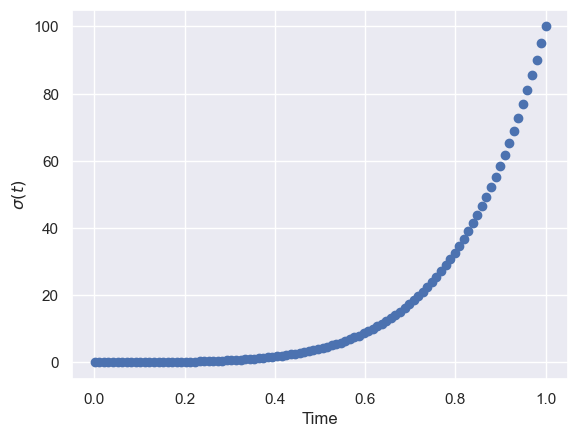

In [59]:
rho = 7.0
sigma_min = 0.01
sigma_max = 100
num_steps = 100
time_steps = torch.linspace(1e-3, 1, num_steps)
sigma_steps = (sigma_min ** (1 / rho) +  time_steps * (sigma_max ** (1 / rho) - sigma_min ** (1 / rho))) ** rho

plt.scatter(time_steps, sigma_steps)
plt.xlabel("Time")
plt.ylabel("$\sigma(t)$")
plt.show()

In [60]:
model.denoiser.eval().to(device)
print()

## Manual Implementation of the dH/dt

In [62]:
# Choose a time step
t = torch.ones(x.shape[0], device=device) * 0.1
x = x.to(device)
noise = noise.to(device)

sigma_t = (sigma_min ** (1 / rho) +  t * (sigma_max ** (1 / rho) - sigma_min ** (1 / rho))) ** rho
sigma_t = torch.ones(x.shape[0], device=device) * sigma_t
sigma_t = expand_dims(sigma_t, 2)
print(sigma_t.shape)

x_t = x + noise * sigma_t
score = model.compute_score(x_t, sigma_t)
signal_t = model.noise_sampler.signal(t)

mean_square_l2_norm_score = torch.mean(torch.sum(score**2, dim=-1))
D = 2
entropy_derivative = D/t - signal_t**2 * sigma_t * mean_square_l2_norm_score 
entropy_derivative.mean()

torch.Size([256, 1])


tensor(6.7310, device='cuda:0', grad_fn=<MeanBackward0>)

### Validation 

In [63]:
%reload_ext autoreload
%autoreload 2

from models.entropy_analysis import EntropyAnalyzer

entropy_analyzer = EntropyAnalyzer(model)
entropy_analyzer.compute_time_derivative_entropy(x_t, t)

tensor(19.9434, device='cuda:0', grad_fn=<MeanBackward0>)

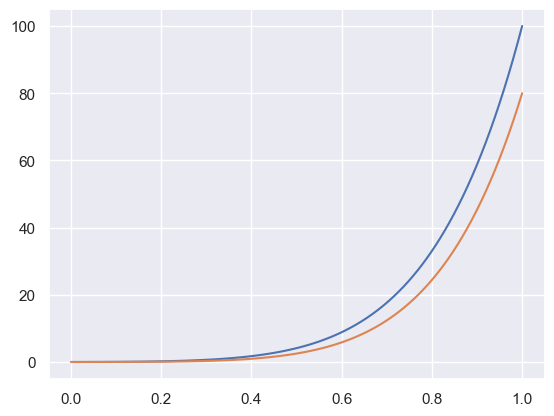

In [64]:
time_steps = torch.linspace(1e-3, 1, 100)
sigmas = (sigma_min ** (1 / rho) +  time_steps * (sigma_max ** (1 / rho) - sigma_min ** (1 / rho))) ** rho

sigmas2 = LogNormalNoiseSampler().sigma(time_steps)

plt.plot(time_steps, sigmas)
plt.plot(time_steps, sigmas2)
plt.show()

In [65]:
from tqdm import tqdm

Computing entropy derivatives: 100%|██████████| 100/100 [00:00<00:00, 531.68it/s]


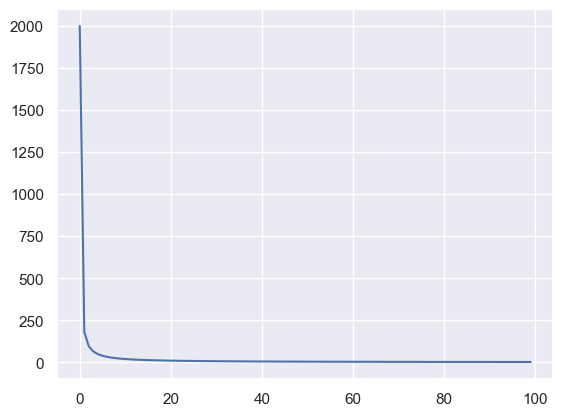

In [66]:
entropy_derivatives = []

with torch.no_grad():
    for t in tqdm(time_steps, desc="Computing entropy derivatives"):
        t = torch.ones(x.shape[0], device=device) * t
        entropy_derivatives.append(entropy_analyzer.compute_time_derivative_entropy(x, t))

entropy_derivatives = torch.stack(entropy_derivatives)

plt.plot(entropy_derivatives.cpu().numpy())

Computing entropy derivatives: 100%|██████████| 100/100 [00:00<00:00, 531.21it/s]


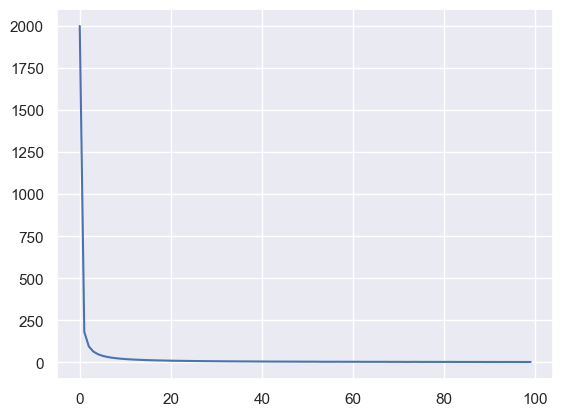

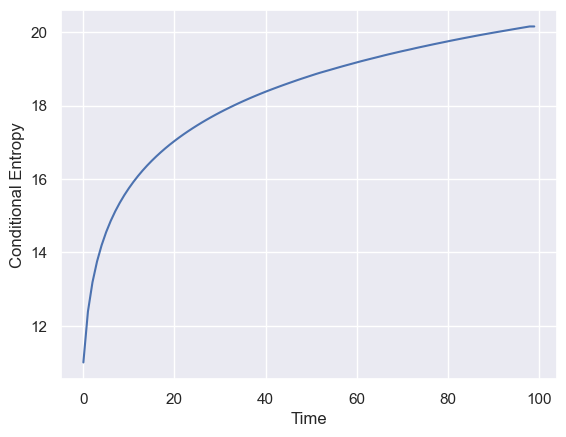

In [67]:
entropy_derivatives = entropy_analyzer.get_entropy_derivative(x, time_steps)
plt.plot(entropy_derivatives.cpu().numpy())
plt.show()

conditional_entropy = entropy_analyzer.compute_conditional_entropy(entropy_derivatives, time_steps)
plt.plot(conditional_entropy.cpu().numpy())
plt.ylabel("Conditional Entropy")
plt.xlabel("Time")
plt.show()


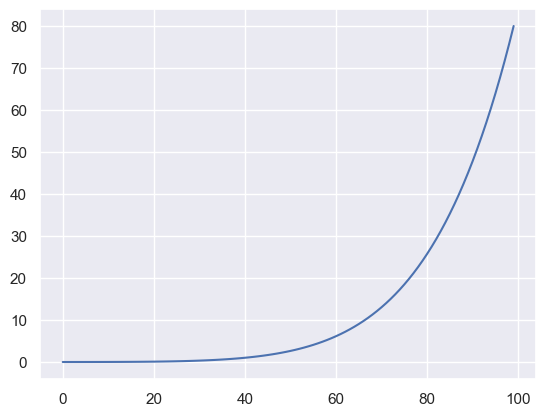

In [68]:
noise_sampler = model.noise_sampler

# Get timesteps linearly spaced between 1e-3 and 1
timesteps = torch.linspace(1e-3, 1, 100)

# Get noise levels
sigmas = noise_sampler.sigma(timesteps)

# Get score function
# score = model.compute_score(x, timesteps)

plt.plot(sigmas)



In [ ]:
entropy_analyzer.plot_entropy_over_time(time_steps.cpu().numpy(), entropy_derivatives.cpu().numpy())

In [16]:



x = x.to(device)
t = 0.1 * torch.ones(x.shape[0], device=device)

noise = torch.randn_like(x)
sigmas = sigma_sampler.sigma(t)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(100):
    for batch in dataloader:
        x, _ = batch
        loss = net.get_loss(x, None)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

In [ ]:
epochs = 100

for epoch in range(epochs):
    for batch in dataloader:
        x, _ = batch
        t = torch.rand(x.shape[0])
        t = t.unsqueeze(-1)
        x_noised = toy_dm.noise_fn(x, t)